# Lour's Pork Barrel Classifier (羅老師肉桶文本分類器)🐖
## Convolutional Neural Networks for Pork Barrel Project Classification 

-------------------------

### Stage 1: Libaries & Dependencies

In [1]:
# built-in library
import math
import re
import collections
import zipfile
from itertools import chain

# ML & Deep Learning/ NLP toolkit
import pandas as pd
import numpy as np
import jieba
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

-------------------------

### Stage 2: Data Preprocessing

#### (1) Read file 

In [2]:
# read file
df = pd.read_csv('data/Pork Bill - 20210519.csv',encoding='utf-8')

# combine abstract of bill and title 
df['text'] =  df['Title'] + df['Content'].fillna(df['Title'])

# drop conten without having any characters
# view na's row: df[df['text'].isnull()==True]
data = df[['text', 'pork_bill']].dropna(subset=['text'])

In [3]:
print(" Pork Legislation", data['pork_bill'].value_counts()[1],'\n', 
      "None-Pork Legislation", data['pork_bill'].value_counts()[0])

 Pork Legislation 1418 
 None-Pork Legislation 2602


#### (2) Tokenization

In [4]:
import collections
import numpy as np
import jieba
from itertools import chain


def jieba_cut(filename):
    """
    cut Chinese and remove stop words
    Reference: https://www.cnblogs.com/Luv-GEM/p/10836454.html
    Stopwords: https://www.kaggle.com/rikdifos/english-and-chinese-stopwords?select=cn_stopwords.txt
    """
    stop_list = [i.strip() for i in open('cn_stopwords.txt','r',encoding='utf-8')]  
    news_cut = []
    news_list = []
    for line in filename:    
        if line:
            news_cut = list(jieba.cut(''.join(line),cut_all=False,HMM=True))  
            news_list.append([word.strip() for word in news_cut if word not in stop_list and len(word.strip())>0]) 
    news_list = list(chain.from_iterable(news_list))  
    return news_list

def clearPucts(context):
    """
    remove punctuation
    ref: https://chenyuzuoo.github.io/posts/28001/
    """
    context = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "", context)
    context = re.sub("[【】╮╯▽╰╭★→「」]+","", context)
    context = re.sub("！，❤。～《》：（）【】「」？”“；：、","",context)
    context = re.sub("\s","",context)
    return context

def seg_char(sent):
    """
    cut Chinese and remove stop words
    ref: https://blog.csdn.net/renyuanfang/article/details/86487367
    """
    # split
    pattern_char_1 = re.compile(r'([\W])')
    parts = pattern_char_1.split(sent)
    parts = [p for p in parts if len(p.strip())>0]
    # cut sentence
    pattern = re.compile(r'([\u4e00-\u9fa5])')
    chars = pattern.split(sent)
    chars = [w for w in chars if len(w.strip())>0]
    chars = ' '.join(chars)
    return chars

# import spacy
# # python3 -m spacy download zh_core_web_sm
# spacy_nlp = spacy.load("zh_core_web_sm")

# data_clean = [clearPucts(text) for text in data.text]
# data_clean = [[spacy_nlp(sentence).vector for sentence in data] for data in data_clean]

In [5]:
data_clean = [seg_char(text) for text in [clearPucts(text) for text in data.text]]

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    data_clean, target_vocab_size=2**18)

data_inputs = [tokenizer.encode(sentence) for sentence in data_clean]

#### (3) Padding

In [6]:
MAX_LEN = max([len(sentence) for sentence in data_clean])
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs,
                                                            value=0,
                                                            padding="post",
                                                            maxlen=MAX_LEN)


#### (4) Spliting Training/ Testing Set

In [7]:
data_labels = data.pork_bill.values

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split
train_inputs, test_inputs, train_labels, test_labels = train_test_split(
    data_inputs, data_labels, test_size=0.33, random_state=42)

print("Shape of X Train:", train_inputs.shape, '\n'
      "Shape of X Test :", test_inputs.shape,'\n'
      "Shape of Y Trian:", train_labels.shape , '\n'
      "Shape of Y Test :", test_labels.shape )

Shape of X Train: (2693, 133) 
Shape of X Test : (1327, 133) 
Shape of Y Trian: (2693,) 
Shape of Y Test : (1327,)


In [9]:
unique_train_labels, counts_train_labels = np.unique(train_labels, return_counts=True)

print(' Num of Train Set:' , train_inputs.shape[0], '\n'
      ,'Not Pork vs Pork:', dict(zip(unique_train_labels, counts_train_labels)))

 Num of Train Set: 2693 
 Not Pork vs Pork: {0: 1741, 1: 952}


In [10]:
unique_test_labels, counts_test_labels = np.unique(test_labels, return_counts=True)

print(' Num of Test Set:' , test_inputs.shape[0], '\n'
      ,'Not Pork vs Pork:', dict(zip(unique_test_labels, counts_test_labels)))

 Num of Test Set: 1327 
 Not Pork vs Pork: {0: 861, 1: 466}


-------------------------


### Stage 3: Model and Building

#### (1) Using the Subclassing API to Build Dynamic Model

In [11]:
class DCNN(tf.keras.Model):
    
    def __init__(self,
                 vocab_size,
                 emb_dim=128,
                 nb_filters=100,
                 FFN_units=512,
                 nb_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="dcnn"):
        super(DCNN, self).__init__(name=name)
        
        self.embedding = layers.Embedding(vocab_size, 
                                          emb_dim)
        self.bigram = layers.Conv1D(filters=nb_filters, 
                                    kernel_size=2,
                                    padding="valid",
                                    activation="relu")
        self.trigram = layers.Conv1D(filters=nb_filters,
                                     kernel_size=3,
                                     padding="valid",
                                     activation="relu")
        self.fourgram = layers.Conv1D(filters=nb_filters,
                                      kernel_size=4,
                                      padding="valid",
                                      activation="relu")
        self.pool = layers.GlobalMaxPool1D() # no training variable so we can
                                             # use the same layer for each
                                             # pooling step
        self.dense_1 = layers.Dense(units=FFN_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        self.last_dense = layers.Dense(units=1, activation="sigmoid")
    
    def call(self, inputs, training):
        x = self.embedding(inputs)
        x_1 = self.bigram(x)
        x_1 = self.pool(x_1)
        x_2 = self.trigram(x)
        x_2 = self.pool(x_2)
        x_3 = self.fourgram(x)
        x_3 = self.pool(x_3)
        
        merged = tf.concat([x_1, x_2, x_3], axis=-1) # (batch_size, 3 * nb_filters)
        merged = self.dense_1(merged)
        merged = self.dropout(merged, training)
        output = self.last_dense(merged)        
        return output


In [12]:
VOCAB_SIZE = 7000   # 5000 tokenizer.vocab_size
EMB_DIM = 200
NB_FILTERS = 100
FFN_UNITS = 256
NB_CLASSES = 2 #len(set(train_labels))
DROPOUT_RATE = 0.2
BATCH_SIZE = 32
NB_EPOCHS = 80

Dcnn = DCNN(vocab_size=VOCAB_SIZE,
            emb_dim=EMB_DIM,
            nb_filters=NB_FILTERS,
            FFN_units=FFN_UNITS,
            nb_classes=NB_CLASSES,
            dropout_rate=DROPOUT_RATE)

#### (2) Compile and Summary of the Model

In [13]:
Dcnn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
Dcnn.build(input_shape = (133 , EMB_DIM)) # (train_inputs.shape[1] , EMB_DIM)
Dcnn.summary()

Model: "dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  1400000   
_________________________________________________________________
conv1d (Conv1D)              multiple                  40100     
_________________________________________________________________
conv1d_1 (Conv1D)            multiple                  60100     
_________________________________________________________________
conv1d_2 (Conv1D)            multiple                  80100     
_________________________________________________________________
global_max_pooling1d (Global multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  77056     
_________________________________________________________________
dropout (Dropout)            multiple                  0      

#### (3) Check Point Path

In [14]:
checkpoint_path = "checkpoint_recode/ckpt_manager"

ckpt = tf.train.Checkpoint(Dcnn=Dcnn)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=10)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Checkpoint Located!!")

-------------------------

### Stage 4: Train the Model

In [15]:
early_stop = EarlyStopping(monitor='val_loss',patience=5)

In [16]:
Dcnn.fit(train_inputs,
         train_labels,
         validation_data=(test_inputs, test_labels),
         batch_size=BATCH_SIZE,
         epochs=NB_EPOCHS,
         callbacks=[early_stop])
ckpt_manager.save()

Epoch 1/80
85/85 [==============================] - 5s 47ms/step - loss: 0.3825 - accuracy: 0.8180 - val_loss: 0.1609 - val_accuracy: 0.9472
Epoch 2/80
85/85 [==============================] - 4s 46ms/step - loss: 0.0817 - accuracy: 0.9751 - val_loss: 0.1186 - val_accuracy: 0.9638
Epoch 3/80
85/85 [==============================] - 4s 48ms/step - loss: 0.0255 - accuracy: 0.9941 - val_loss: 0.1234 - val_accuracy: 0.9638
Epoch 4/80
85/85 [==============================] - 4s 44ms/step - loss: 0.0173 - accuracy: 0.9967 - val_loss: 0.1247 - val_accuracy: 0.9661
Epoch 5/80
85/85 [==============================] - 4s 43ms/step - loss: 0.0198 - accuracy: 0.9970 - val_loss: 0.1512 - val_accuracy: 0.9638
Epoch 6/80
85/85 [==============================] - 4s 44ms/step - loss: 0.0148 - accuracy: 0.9978 - val_loss: 0.1274 - val_accuracy: 0.9668
Epoch 7/80
85/85 [==============================] - 4s 44ms/step - loss: 0.0096 - accuracy: 0.9981 - val_loss: 0.1241 - val_accuracy: 0.9676


'checkpoint_recode/ckpt_manager/ckpt-1'

-------------------------

### Stage 5: Evaluation

In [17]:
losses = pd.DataFrame(Dcnn.history.history)
losses

,loss,accuracy,val_loss,val_accuracy
0,0.382547,0.818047,0.160920,0.947249
1,0.081730,0.975121,0.118627,0.963828
2,0.025506,0.994059,0.123439,0.963828
3,0.017322,0.996658,0.124735,0.966089
4,0.019838,0.997029,0.151229,0.963828
5,0.014844,0.997772,0.127444,0.966842
6,0.009641,0.998143,0.124088,0.967596


##### Too much overfitting due toless validation set ⚠️⚠️⚠️⚠️

<AxesSubplot:>

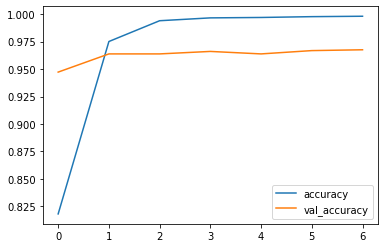

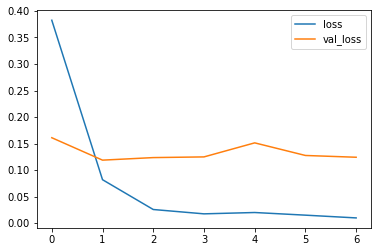

In [18]:
losses[['accuracy','val_accuracy']].plot()
losses[['loss','val_loss']].plot()

In [19]:
from sklearn.metrics import classification_report,confusion_matrix

In [20]:
evaluation_model = Dcnn.evaluate(test_inputs, test_labels, batch_size=BATCH_SIZE)
print(evaluation_model)

42/42 [==============================] - 0s 5ms/step - loss: 0.1241 - accuracy: 0.9676
[0.12408772855997086, 0.9675960540771484]


In [21]:
# pd.DataFrame(confusion_matrix(test_labels,predictions))
predictions = Dcnn.predict(test_inputs)
predictions = np.where(predictions >0.8 , 1, 0)
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       861
           1       0.97      0.94      0.95       466

    accuracy                           0.97      1327
   macro avg       0.97      0.96      0.96      1327
weighted avg       0.97      0.97      0.97      1327



In [22]:
t = pd.DataFrame(confusion_matrix(test_labels,predictions), 
             columns=['Predictions: Not Pork(0)','Predictions:Pork(1)'])
t.index = ['Acutal: Not Pork(0)', 'Acutal: Pork (1)']
t

,Predictions: Not Pork(0),Predictions:Pork(1)
Acutal: Not Pork(0),846,15
Acutal: Pork (1),30,436


-------------------------

### Stage 6: Try the Model with New Data and Export an End-to-end Model


#### (1) Test New Dataset from 200 samples from Leislative Questions

In [23]:
def as_num(x):
    """
    keep 10 decimals
    """
    y = '{:.15f}'.format(x) 
    return y

In [24]:
import pandas as pd
import random

# test the trined model using new text from 200 samples from Leislative Questions
LQ6 = pd.read_csv('data/LQ_6th.csv')

# drop '0': legislor  never have proposed any legisaltive questions. 
LQ6 = LQ6[LQ6['title'].isin(['0'])== False]

# select text with number of charecters within EMB_DIM; len(sub_set) = 11162
# sample_df = LQ6.loc[[len(char_num) for char_num in LQ6.title if len(char_num) < MAX_LEN], ['legislator','title', 'topic', 'category', 'keywords', 'ques_type']].reset_index(drop=True)
sample_df = LQ6.iloc[random.sample(range(len(LQ6)), 2000)][['legislator', 'title', 'topic', 'category', 'keywords', 'ques_type']]
sub_set = [seg_char(text) for text in [clearPucts(text) for text in sample_df.title]]


##### Top 10 of 2000 Sampled Legislative Questions

In [25]:
pd.DataFrame(
    {'legislator': sample_df.legislator,
     'Pork Value(Constituency Interest)':[as_num(Dcnn(np.array([tokenizer.encode(line)]), training=True).numpy()[0][0]) for line in sub_set],
     'Legislative Questions ': sample_df.title,
     'Topic': sample_df.topic,
     'Key Word':sample_df.keywords}).sort_values(by=['Pork Value(Constituency Interest)'], ascending = False).head(10)

,legislator,Pork Value(Constituency Interest),Legislative Questions,Topic,Key Word
8795,賴士葆,0.997264862060547,對行政院所屬勞工保險局發放有關福利敬老津貼有失周詳，不合公道一案，特向行政院提出質詢。,老人福利,勞工保險局 ; 福利敬老津貼
9109,邱鏡淳,0.996278405189514,就政府為減緩政府財政負擔及維持退休人員與現職人員權益的平衡，推行「教育人員退休所得合理化方案...,教育人員退休 ; 退休金,教育人員 ; 退休所得
4594,林鴻池,0.996166765689850,針對目前政府十三萬臨時人員已依勞退新制提撥退休金，但仍尚未納入勞基法保障，政府應儘速公布將臨...,勞動基準 ; 聘僱人員 ; 法律適用範圍,臨時人員 ; 勞基法
3999,林正峰,0.995356976985931,針對政府準備修法推動「二代健保」，健保保費採取「年度所得總額」為計算基礎，而非採用扣除免稅額...,國民 ; 健康保險 ; 保險費,二代健保 ; 年度所得總額
8876,賴清德,0.990603744983673,為改善低所得家庭就業困難，提昇其工作所得，使脫離貧窮困境，特向行政院提出質詢。,低收入戶 ; 就業,低所得家庭 ; 就業困難
4418,林重謨,0.989980101585388,針對財政部關於遺產及贈與稅制之改革一事，特向行政院提出質詢。,遺產稅 ; 贈與稅 ; 賦稅改革,遺產稅 ; 贈與稅
4438,林重謨,0.989181876182556,針對國防部當初為了因應政府取消軍教免稅優惠，將志願役軍士官勤務加給自八十九年七月起調高，平均...,軍人 ; 教育人員 ; 課稅,軍教課稅
3411,林建榮,0.988365650177002,為建請回復「漁業動力用油優惠標準」百分之二十八之補助措施，以扶助弱勢漁民生計，特向行政院提出質詢。,漁業補助,漁業動力用油優惠標準
7832,羅志明,0.986930191516876,針對為照顧弱勢農民，高雄市及各地方政府為都市城鄉發展之均衡，高雄市的都市周邊區域之小港區應比...,農業補助,小港區 ; 重工業回饋地方基金 ; 資助農民
8671,費鴻泰,0.986919820308685,針對政府公教貸款利率高於一般商業銀行專案辦理之房屋貸款利率，使公教人員之房貸利息負擔沈重依舊...,公務員福利 ; 房屋貸款 ; 利率,公教貸款利率


##### Last 10 Rows of 2000 Sampled Legislative Questions

In [26]:
pd.DataFrame(
    {'legislator': sample_df.legislator,
     'Pork Value(Constituency Interest)':[as_num(Dcnn(np.array([tokenizer.encode(line)]), training=True).numpy()[0][0]) for line in sub_set],
     'Legislative Questions ': sample_df.title,
     'Topic': sample_df.topic,
     'Key Word':sample_df.keywords}).sort_values(by=['Pork Value(Constituency Interest)'], ascending = False).tail(10)

,legislator,Pork Value(Constituency Interest),Legislative Questions,Topic,Key Word
10557,高思博,0.000012218362826,鑑於「麥肯卡債報告」與行政院金融監督管理委員之卡債協商報告，落差極大，金管會應儘速公布小額信...,金融管理 ; 債務,麥肯卡債報告 ; 卡債協商
7660,羅世雄,0.000011173857274,針對若干不肖業者以「課程大放送」方式，規避定型化契約規範，欺瞞消費者，爰此，主管單位應提出立...,語言 ; 補習班 ; 消費者保護,定型化契約 ; 語言補習班
9923,陳啟昱,0.000007897281648,針對高雄港港區監視系統，得標廠商與港務局就監視系統規格有所爭議，經行政院公共工程委員會調解，...,商港 ; 工程招標 ; 電子監視,高雄港 ; 監視系統
9626,鄭朝明,0.000007136633940,有鑒於近年消費金融債務糾紛頻傳，部分討債公司採取討債手法過於激烈，其中包括潑灑油漆、半夜恐嚇...,金融管理 ; 債務 ; 暴力,金融債務 ; 討債公司
776,吳敦義,0.000006591444617,有鑑於福建省政府委員之職務係在監督縣自治事項及辦理其他行政院交辦事項，然現任福建省政府委員、...,政府官員 ; 行政中立,福建省政府委員 ; 陳滄江 ; 拉票
4704,柯淑敏,0.000005787265309,針對台灣已進入金控年代，但目前主管機關仍然是以分業的法規來監理金控旗下各子公司的轉投資，造成...,金融業 ; 金融管理,金控 ; 子公司 ; 轉投資
10295,陳瑩,0.000005518909347,有鑑於國內監聽情況嚴重氾濫，直接侵犯人民隱私權，為維護基本人權以及控管監聽行為獨立性，監聽審...,竊聽 ; 人權,監聽 ; 基本人權
4356,林進興,0.000004838947007,針對行政院金融監督管理委員會為了解決國人廣大的卡債問題，積極推廣債務協商機制，政策本意良好，...,信用卡 ; 債務,卡債 ; 協商機制
7560,紀國棟,0.000003577750704,鑑於監視器是維持治安不可或缺之工具，惟監視器維修經費龐大，若遇颱風豪雨嚴重損壞費用很高，多數...,電子監視,監視器.損壞維修
6784,王昱婷,0.000002748315183,針對我國各產險業者長期有聯合壟斷之情事發生，嚴重影響臺灣社會消費者之權益。惟礙於現行法令，如...,金融管理 ; 保險業,產險業 ; 聯合壟斷


#### (2) Export an End-to-end Model


In [27]:
from tensorflow.keras.models import load_model

In [ ]:
# Get model (Sequential, Functional Model, or Model subclass)
Dcnn.save('lour_pork_model')

In [29]:
from tensorflow import keras
model = keras.models.load_model('lour_pork_model')